In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1)
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2)

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 7, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 0)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_r1b2_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 7, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 0)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)


In [73]:
def train_unpaired(model_rna, model_atac, disc, data_loader_rna, data_loader_atac, diff_sim_rna, 
                   diff_sim_atac, optimizer_rna, optimizer_atac, optimizer_D, P_rna = None, P_atac = None, n_epochs = 50, 
                   n_iter = 15, n_iter2 = 1, lamb_r_rna = 1, lamb_r_atac = 1, lamb_disc = 1, dist_mode = "inner_product"):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for epoch in range(n_epochs):
        iteration = zip(data_loader_rna, data_loader_atac)
        for data in iteration:
            
            # Update RNA Encoder
            data_rna, data_atac = data
            batch_cols_rna = data_rna['index'].to(device)
            batch_sim_rna = diff_sim_rna[batch_cols_rna,:][:,batch_cols_rna]
            batch_expr_rna = data_rna['count'].to(device)
            # batch P
            if dist_mode == "kl":
                batch_P_rna = P_rna[batch_cols_rna, :][:, batch_cols_rna]
            else:
                batch_P_rna = None

            batch_expr_r_rna = model_rna(batch_expr_rna)
            z_rna = model_rna[:1](batch_expr_rna)
            train_loss_rna, loss_recon_rna, loss_dist_rna = traj_loss(recon_x = batch_expr_r_rna, x = batch_expr_rna, z = z_rna, 
            diff_sim = batch_sim_rna, Pt = batch_P_rna, lamb_recon = lamb_r_rna, lamb_dist = 1, recon_mode = "relative", dist_mode = dist_mode)

            train_loss_rna.backward()
            optimizer_rna.step()
            optimizer_rna.zero_grad()

            # Update ATAC Encoder
            batch_cols_atac = data_atac['index'].to(device)
            batch_sim_atac = diff_sim_atac[batch_cols_atac,:][:,batch_cols_atac]
            batch_expr_atac = data_atac['count'].to(device)
            # batch U_t
            if dist_mode == "kl":
                batch_P_atac = P_atac[batch_cols_atac, :][:, batch_cols_atac]
            else:
                batch_P_atac = None

            batch_expr_r_atac = model_atac(batch_expr_atac)
            z_atac = model_atac[:1](batch_expr_atac)
            train_loss_atac, loss_recon_atac, loss_dist_atac = traj_loss(recon_x = batch_expr_r_atac, x = batch_expr_atac, z = z_atac, 
            diff_sim = batch_sim_atac, Pt = batch_P_atac, lamb_recon = lamb_r_atac, lamb_dist = 1, recon_mode = "relative", dist_mode = dist_mode)

            train_loss_atac.backward()
            optimizer_atac.step()
            optimizer_atac.zero_grad()

            z_rna = model_rna[:1](batch_expr_rna).detach()
            z_atac = model_atac[:1](batch_expr_atac).detach()

            # Update Discriminator
            D_loss_avg = 0
            for i in range(n_iter):
                D_loss = torch.mean(disc(z_rna)) - torch.mean(disc(z_atac))
                D_loss_avg += D_loss.item()
                D_loss.backward()
                optimizer_D.step()
                optimizer_D.zero_grad()
                # Weight clipping
                for p in disc.parameters():
                    p.data.clamp_(-0.001, 0.001)
            D_loss_avg /= n_iter

            # Update Encoder
            for i in range(n_iter2):
                z_rna = model_rna[:1](batch_expr_rna)
                E_loss = -torch.mean(disc(z_rna))
                E_loss.backward()
                optimizer_rna.step()
                optimizer_rna.zero_grad()


        if epoch % 10 == 0:
            log_rna = "RNA loss: {:.5f}, RNA recon loss: {:.5f}, RNA dist loss: {:.5f}".format(train_loss_rna.item(), loss_recon_rna.item(), loss_dist_rna.item())
            log_atac = "ATAC loss: {:.5f}, ATAC recon loss: {:.5f}, ATAC dist loss: {:.5f}".format(train_loss_atac.item(), loss_recon_atac.item(), loss_dist_atac.item())
            log_D = "Discriminator loss: {:.5f}".format(D_loss_avg)
            print("epoch: ", epoch, log_rna, log_atac, log_D)

In [74]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

disc = ae.w_discriminator(hidden1 = 32, hidden2 = 16, hidden3 = 1).to(device)

optimizer_rna = torch.optim.RMSprop(ae1.parameters(), lr = 5e-5)
optimizer_atac = torch.optim.RMSprop(ae2.parameters(), lr = 5e-5)
optimizer_D = torch.optim.RMSprop(disc.parameters(), lr = 5e-5)

In [75]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, P_rna= U_t1, P_atac= U_t2, n_epochs=1, n_iter=10, n_iter2 = 1, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=1, dist_mode = "inner_product")

tensor([[-2.4937e+00, -1.8347e-01],
        [-6.3754e-01,  4.4757e-01],
        [ 8.3413e-01, -1.4037e-01],
        [ 3.4688e-01, -6.4802e-01],
        [ 3.2447e-01, -8.3992e-02],
        [ 1.1119e+00,  2.1060e-01],
        [-1.1159e+00, -3.9787e-01],
        [ 6.3245e-01,  7.8988e-02],
        [-2.4059e-01, -6.9650e-01],
        [ 5.2195e-01, -5.7258e-01],
        [ 7.1322e-01,  3.0230e-01],
        [-2.4415e-01,  2.4981e-01],
        [ 8.0450e-01,  3.9715e-02],
        [ 9.6436e-01,  1.4115e-02],
        [-5.5758e-01,  1.0888e+00],
        [-2.4063e+00, -8.6549e-01],
        [-1.0169e+00, -2.0491e+00],
        [ 7.8094e-01, -2.1224e-02],
        [-3.8755e-01, -3.8413e-01],
        [-3.9330e-01, -8.8078e-01],
        [ 7.4368e-01, -3.2485e-01],
        [-6.2234e-01,  4.1740e-01],
        [-3.1960e-01, -1.9757e+00],
        [ 9.0378e-01,  1.4757e-01],
        [-4.8269e+00, -1.8777e+00],
        [-1.8927e+00, -1.6788e+00],
        [-3.9234e-01, -4.1816e-01],
        [-1.1818e+00, -2.460

RuntimeError: The size of tensor a (241) must match the size of tensor b (223) at non-singleton dimension 0

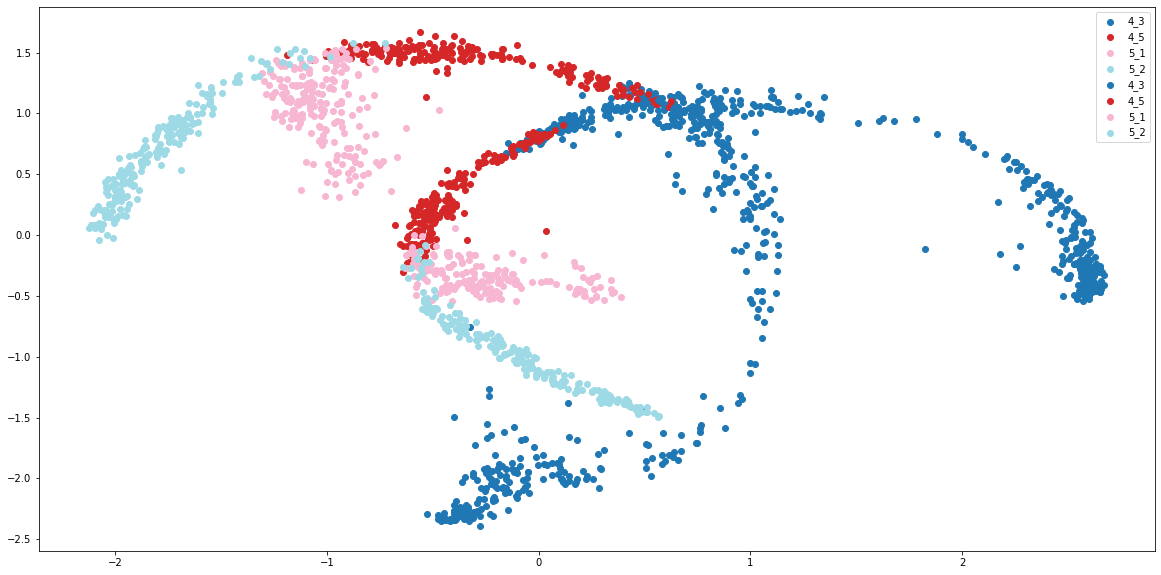

In [67]:
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels["pop"], anno2 = symsim_r1b2.cell_labels["pop"], mode = "joint",save = None)